### Описание проекта

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.   
Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.
* Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. 
* Проанализируйте возможную прибыль и риски техникой Bootstrap.

In [29]:
# pip install pandas-profiling

### Импорт бибилиотек

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>



### Закгрузка датасета

In [31]:
try:
    df0 = pd.read_csv('./datasets/geo_data_0.csv')
    df1 = pd.read_csv('./datasets/geo_data_1.csv')
    df2 = pd.read_csv('./datasets/geo_data_2.csv')
except:
    df0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
display(df0.head(2),df1.head(2),df2.head(2))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

Пропущенных данных нет, тип данных - float, предобработка не требуется

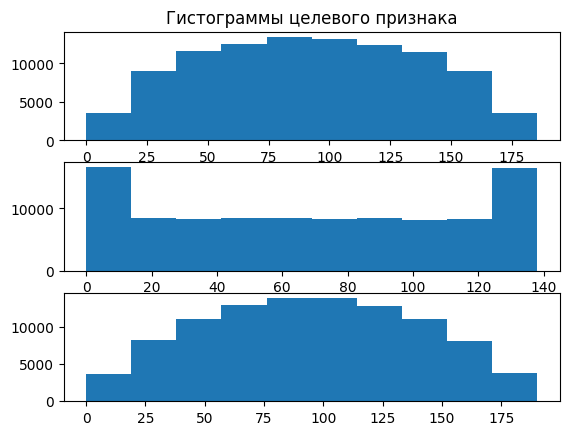

In [32]:
%matplotlib inline

plt.subplot(3, 1, 1)
plt.hist(df0['product'])
plt.title('Гистограммы целевого признака')
plt.subplot(3, 1, 2)
plt.hist(df1['product'])
plt.subplot(3, 1, 3)
plt.hist(df2['product'])
plt.show()

* geo_0 и geo_2 нормально распределены вокруг среднего, а geo_1 от них отличается.
* Т.к. нам требуется предсказывать добычу в регионе воспользуемся моделями 

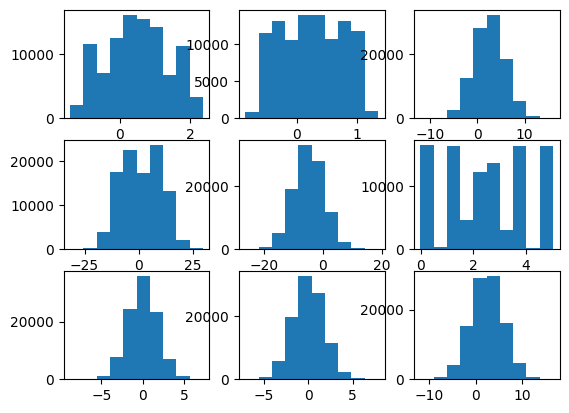

In [33]:
def graph(df,col,i):
    plt.subplot(3,3,i)
    plt.hist(df[col])
dfs = [df0,df1,df2]
cols = ['f0','f1','f2']
i = 1
for df in dfs:
    for col in cols:
        graph(df,col,i)
        i += 1

По признакам существенные отличия также у geo_1

In [34]:
for df in dfs:
    display(df.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Смущает наличие истощенных скважин, но с другой стороны модель учтет это

In [35]:
# Разделим каждый датасет не признаки и целевой столбец
X_0 = df0.drop(['product','id'], axis = 1)
X_1 = df1.drop(['product','id'], axis = 1)
X_2 = df2.drop(['product','id'], axis = 1)
y_0 = df0['product']
y_1 = df1['product']
y_2 = df2['product']

In [36]:
# Разделим датасеты на тренировочную и валидационную выборки
X_0_train, X_0_valid, y_0_train, y_0_valid = train_test_split(X_0, y_0, test_size=0.25, random_state=12345)
X_1_train, X_1_valid, y_1_train, y_1_valid = train_test_split(X_1, y_1, test_size=0.25, random_state=12345)
X_2_train, X_2_valid, y_2_train, y_2_valid = train_test_split(X_2, y_2, test_size=0.25, random_state=12345)
print ('Размер тренировочной выборки 0', X_0_train.shape, y_0_train.shape)
print ('Размер тренировочной выборки 1', X_1_train.shape, y_1_train.shape)
print ('Размер тренировочной выборки 2', X_2_train.shape, y_2_train.shape)
print ('Размер валидационной выборки 0', X_0_valid.shape, y_0_valid.shape)
print ('Размер валидационной выборки 1', X_1_valid.shape, y_1_valid.shape)
print ('Размер валидационной выборки 2', X_2_valid.shape, y_2_valid.shape)

Размер тренировочной выборки 0 (75000, 3) (75000,)
Размер тренировочной выборки 1 (75000, 3) (75000,)
Размер тренировочной выборки 2 (75000, 3) (75000,)
Размер валидационной выборки 0 (25000, 3) (25000,)
Размер валидационной выборки 1 (25000, 3) (25000,)
Размер валидационной выборки 2 (25000, 3) (25000,)


In [37]:
#Обучим модель на тренировочных данных
model_0 = LinearRegression()
model_1 = LinearRegression() 
model_2 = LinearRegression()
model_0.fit(X_0_train,y_0_train)
model_1.fit(X_1_train,y_1_train)
model_2.fit(X_2_train,y_2_train)
print ('Модель обучена')

Модель обучена


In [38]:
#Получем предсказания
pred_0 = model_0.predict(X_0_valid)
pred_1 = model_1.predict(X_1_valid)
pred_2 = model_2.predict(X_2_valid)

In [39]:
print('RMSE модели_0:', mean_squared_error(y_0_valid, pred_0)**0.5)
print('RMSE модели_1:', mean_squared_error(y_1_valid, pred_1)**0.5)
print('RMSE модели_2:', mean_squared_error(y_2_valid, pred_2)**0.5)

RMSE модели_0: 37.5794217150813
RMSE модели_1: 0.8930992867756165
RMSE модели_2: 40.02970873393434


In [40]:
print('Средний запас сырья в регионе 0:', pred_0.mean())
print('Средний запас сырья в регионе 1:', pred_1.mean())
print('Средний запас сырья в регионе 2:', pred_2.mean())

Средний запас сырья в регионе 0: 92.59256778438035
Средний запас сырья в регионе 1: 68.72854689544602
Средний запас сырья в регионе 2: 94.96504596800489


### Выводы ч. 1
* Точнее всего работает модель 1, средняя ошибка в ней - самая маленькая, менее 1000 баррелей
* Модели 1 и 3 могут допускать ошибку в 37-40 тысяч барелей, что довольно много (почти треть от среднего)

### Расчет экономических показателей
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [41]:
# Определим константы исходя из задания
BUDGET = 10_000_000_000
UNIT_PROFIT = 450000
COUNT = 500
BEST_COUNT = 200
# Чтобы скваржина отработать в 0, запаса скважины должно хватить на то, чтобы отбить затраты
BUDGET_1 = BUDGET/200
print ('Бюджет на 1 скважину =', BUDGET_1)
min_product = BUDGET_1/UNIT_PROFIT
print ('Минимальное количество продукта для безубыточной инвестиции =', np.ceil(min_product))

Бюджет на 1 скважину = 50000000.0
Минимальное количество продукта для безубыточной инвестиции = 112.0


* Средние показатели всех 3 регионов ниже минимальной планки для безубыточного производства, при этом судя по гистограммам мы можем найти такие месторождения, где показатель выше минимума
* Теперь у нас все готово, чтобы посчитать какой выхлоп мы получим в каждом из регионов, если начнем разработку 200 лучших скважин

<div class="alert alert-block alert-success">
<b>Успех:</b> Значение для безубыточной разработки посчитано верно, с выводом согласен  
</div>

In [42]:
#Функция для расчета прибыли каждого региона
def profit (target, predict, count):
    target = target.reset_index(drop = True)
    predict = predict.reset_index(drop = True)
    predict_sorted = pd.Series(predict)
    predict_sorted = predict_sorted.sort_values(ascending = False)
    selected = target[predict_sorted.index].head(count)
    return int(UNIT_PROFIT*selected.sum()-BUDGET)

In [43]:
#Теперь нам нужны предсказания по каждой скважине, т.к. мы можем брать в разработку скважины, которые использовались в тренировочных моделях
pred_final_0 = pd.Series(model_0.predict(X_0_valid))
pred_final_1 = pd.Series(model_1.predict(X_1_valid))
pred_final_2 = pd.Series(model_2.predict(X_2_valid))

In [44]:
pred_final_0.head()

0    95.894952
1    77.572583
2    77.892640
3    90.175134
4    70.510088
dtype: float64

In [45]:
# Рассчетаем прибыль с топ 200 точек каждого региона
print ('Максимальная прибыль регион 0 (млрд)', profit(y_0_valid,pred_final_0,200)/1000000000)
print ('Максимальная прибыль регион 1 (млрд)', profit(y_1_valid,pred_final_1,200)/1000000000)
print ('Максимальная прибыль регион 2 (млрд)', profit(y_2_valid,pred_final_2,200)/1000000000)

Максимальная прибыль регион 0 (млрд) 3.320826043
Максимальная прибыль регион 1 (млрд) 2.415086696
Максимальная прибыль регион 2 (млрд) 2.710349963


* В 0 и 2 регионе прибыль составит более 3 млрд рублей, при условии, что удастся разработать самые лучшие скважины.
* В регионе 1 инвестиции не окупятся даже если разработать топ скважины.

In [46]:
# Посчитаем риск уйти в минус в каждом регионе, для этого также сделаем функцию
state = RandomState(12345) 
def bootstrap (target, prediction, count, number):
    values = []
    target.index = prediction.index
    for i in range(count):
        target_subsample = target.sample(n=number, replace=True, random_state=state)
        prediction_subsample = prediction[target_subsample.index]
        values.append(int(profit(target_subsample,prediction_subsample,200)))
    values = pd.Series(values)
    risk = int(len(values[values < 0]))/1000
    #print ((values < 0).mean())

    return pd.Series(values), risk

In [47]:
# Регион 0 расчет метрик
val, k = bootstrap (y_0_valid,pred_final_0,1000,500)
print ('Регион_0, среднее: (млрд) {:.2f}'.format(val.mean()/1000000000))
print ('Регион_0, 2.5% квантиль: (млрд) {:.2f}'.format(val.quantile(0.025)/1000000000))
print ('Регион_0, 97.5% квантиль (млрд): {:.2f}'.format(val.quantile(0.975)/1000000000))
print ('Шанс остаться в убытке : {:.2%}'.format(k))

Регион_0, среднее: (млрд) 0.40
Регион_0, 2.5% квантиль: (млрд) -0.11
Регион_0, 97.5% квантиль (млрд): 0.91
Шанс остаться в убытке : 6.90%


In [48]:
# Регион 1 расчет метрик
val, k = bootstrap (y_1_valid,pred_final_1,1000,500)
print ('Регион_0, среднее: (млрд) {:.2f}'.format(val.mean()/1000000000))
print ('Регион_0, 2.5% квантиль: (млрд) {:.2f}'.format(val.quantile(0.025)/1000000000))
print ('Регион_0, 97.5% квантиль (млрд): {:.2f}'.format(val.quantile(0.975)/1000000000))
print ('Шанс остаться в убытке : {:.2%}'.format(k))

Регион_0, среднее: (млрд) 0.46
Регион_0, 2.5% квантиль: (млрд) 0.08
Регион_0, 97.5% квантиль (млрд): 0.86
Шанс остаться в убытке : 0.70%


In [49]:
# Регион 2 расчет метрик
val, k = bootstrap (y_2_valid,pred_final_2,1000,500)
print ('Регион_0, среднее: (млрд) {:.2f}'.format(val.mean()/1000000000))
print ('Регион_0, 2.5% квантиль: (млрд) {:.2f}'.format(val.quantile(0.025)/1000000000))
print ('Регион_0, 97.5% квантиль (млрд): {:.2f}'.format(val.quantile(0.975)/1000000000))
print ('Шанс остаться в убытке : {:.2%}'.format(k))

Регион_0, среднее: (млрд) 0.39
Регион_0, 2.5% квантиль: (млрд) -0.11
Регион_0, 97.5% квантиль (млрд): 0.93
Шанс остаться в убытке : 6.50%


### Итоговые выводы
* Самый привлекательный регион для инвестиций - регион 1. Шанс не окупиться составляет лишь 0.7% средняя прибыль составит 0.46 млрд. При это даже 2.5% процентиль положительный.
* В 0 и 2 регионе шанс не окупиться около 7%
